# Ensemble model training for Eros and models

---



This code trains ensemble models using reflectance spectra data as input (x) from the "Data" folder. The corresponding calculated exposure times (y) are provided in the "data_all_H_laser.xlsx" file.

**Training Process:**

- A total of 30 models are trained using the provided data.
- Each model is saved in .joblib format for later use.

**Output:**
- The trained models are stored in the "Eros_Models" folder.

In [ ]:
!pip install tensorflow==2.17.1 keras==3.5.0

In [ ]:
!pip install scikeras==0.13.0

In [ ]:
!pip install scikit-learn==1.5.2

In [ ]:
!pip install numpy==1.26.4 joblib==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.2
    Uninstalling joblib-1.5.2:
      Successfully uninstalled joblib-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import sklearn
import joblib
import os
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

In [ ]:
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor,GradientBoostingRegressor,RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split


This function, denoise_and_norm, processes spectral data with optional denoising and normalization. Reflectance spectra have been normalised at 1300 nm

In [ ]:
def denoise_and_norm(data: np.ndarray, wavelength: np.ndarray, denoising: bool, normalising: bool, sigma_nm: float = 7.,
                     normalised_at_wvl: float = 1300.) -> np.ndarray:
    if np.ndim(data) == 1:
        data = np.reshape(data, (1, len(data)))

    if denoising:
        nm_to_px = 1. / (wavelength[1] - wavelength[0])  # conversion from nm to px
        correction = gaussian_filter1d(np.ones(len(wavelength)), sigma=sigma_nm * nm_to_px, mode="constant")
        data_denoised = gaussian_filter1d(data, sigma=sigma_nm * nm_to_px, mode="constant") / correction
    else:
        data_denoised = data

    # Normalised reflectance
    if normalising:
        fun = interp1d(wavelength, data_denoised, kind="cubic")  # v_final differs from v
        v_norm = np.reshape(fun(normalised_at_wvl), (len(data_denoised), 1))
    else:
        v_norm = 1.

    #return data_denoised / v_norm
    return (data_denoised / v_norm).flatten()

In [ ]:
catalogue = pd.read_excel("/Data_Ensemble/data_all_H_laser.xlsx",
                          index_col=None,
                          header=0,
                          na_values=["NA"],
                          engine="openpyxl")

sample_names = np.array(catalogue["Sample name"], dtype=str)
ET_1AU = np.array(catalogue["ET_1AU"], dtype=np.float32)
type = np.array(catalogue["type"], dtype=str)
irradiation = np.array(catalogue["Irradiation"], dtype=int)
log_ET_1AU = np.reshape(np.log10(np.array(catalogue["ET_1AU"], dtype=np.float32) + 1), (-1, 1))
group = np.array(catalogue["group"], dtype=int)

Interpolate reflectance spectra from 820 nm to 2360 nm, with 20-nm intervals
and normalised at 550 nm using the function denoise_and_norm.

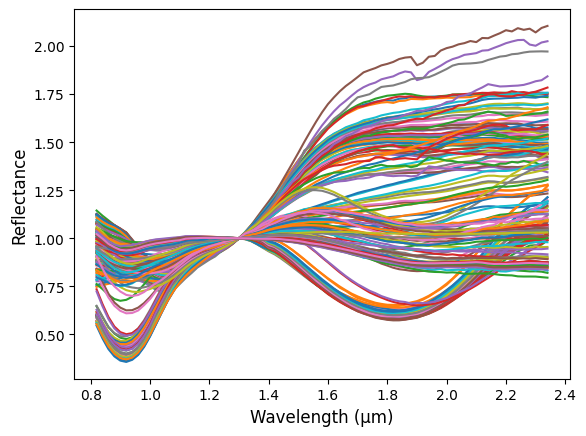

In [ ]:
wavelengths_new = np.arange(820., 2360., 20.)

input_data = np.zeros((len(sample_names), len(wavelengths_new) + 1), dtype=np.float32)  # +1 for band slope

for i, sample_name in enumerate(sample_names):
    # Read the spectrum data from the CSV file
    spectra = pd.read_csv("/Data_Ensemble/Data/" + sample_name + ".csv", header=1)

    wavelengths, spectra = spectra["W"].to_numpy() * 1000., spectra["R"].to_numpy()

    # Interpolate the spectra onto the new wavelengths using cubic interpolation (by ignoring the duplicate values)
    unique_wavelengths, unique_indices = np.unique(wavelengths, return_index=True)
    unique_spectra = spectra[unique_indices]

    interp_func = interp1d(unique_wavelengths, unique_spectra, kind="linear")
    interpolated_spectra = interp_func(wavelengths_new)

    # Call the denoise function
    denoised_normalized_data = denoise_and_norm(interpolated_spectra, wavelengths_new, denoising=True, normalising=True)

    input_data[i, :-1], input_data[i, -1] = denoised_normalized_data, irradiation[i]

    plt.plot(wavelengths_new/1000, denoised_normalized_data)

plt.xlabel("Wavelength (µm)", fontsize=12)
plt.ylabel("Reflectance", fontsize=12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
savefig_kwargs = {"bbox_inches": "tight",
                  "pad_inches": 0.05,
                  "dpi": 100}  # dpi only for jpg/png figures
plt.show()

In [ ]:
print(input_data.shape)

(167, 78)


In [ ]:
#CNN model
def create_cnn_model_1(input_shape,learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation="relu", padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=2, activation="relu", padding="same"))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(1, activation="relu"))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mean_absolute_error"])
    return model

This class extends KerasRegressor to integrate a CNN model for predicting continuous outputs.

In [ ]:
#Custom Keras Regressor class for CNN-based regression tasks.

class CNNRegressor(KerasRegressor):
    _estimator_type = "regressor"

    def __init__(self, input_shape, learning_rate=0.001, epochs=10, batch_size=32, verbose=0, **kwargs):
        super().__init__(**kwargs)
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        #super().__init__(build_fn=self._keras_build_fn, **kwargs)

    def _keras_build_fn(self):
        return create_cnn_model_1(self.input_shape, self.learning_rate)

In [ ]:
output_folder = "/Eros_Models"
os.makedirs(output_folder, exist_ok=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for iteration in range(30):
    print(f"Starting iteration {iteration + 1}")

    iteration_train_indices, iteration_test_indices = [], []

    # Gather train indices for this iteration
    for train_index, _ in skf.split(input_data, group):
        iteration_train_indices.extend(train_index)

    # Use only training data for this iteration
    X_train = input_data[iteration_train_indices]
    y_train = log_ET_1AU[iteration_train_indices]

    # Create the ensemble model
    ensemble_model = VotingRegressor(
        estimators=[
            ('cnn', CNNRegressor(input_shape=(X_train.shape[1], 1), epochs=200, batch_size=32, verbose=1)),
            ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.4, random_state=42)),
            ('knn', KNeighborsRegressor(n_neighbors=3)),
            ('etr', ExtraTreesRegressor(n_estimators=100, random_state=42)),
            ('rft', RandomForestRegressor(n_estimators=100, random_state=42))
        ],
        weights=[4, 4, 1, 5, 1],
        n_jobs=5
    )

    # Train the model
    ensemble_model.fit(X_train, y_train.ravel())

    #Save the trained model for this iteration in the 'models' folder
    model_filename = os.path.join(output_folder, f"En_Eros_{iteration + 1}.joblib")
    joblib.dump(ensemble_model, model_filename)
    print(f"Model for iteration {iteration + 1} saved to {model_filename}")

print("All models trained and saved.")

Starting iteration 1
